# **Data Profiling**

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load dataset
print("--- MEMUAT DATA ---")

df_tracking = pd.read_excel('developer_journey_trackings.xlsx')
df_exam_res = pd.read_excel('exam_results.xlsx')
df_exam_reg = pd.read_excel('exam_registrations.xlsx')
print(f"✅ Data Tracking dimuat: {df_tracking.shape[0]} baris")
print(f"✅ Data Exam Results dimuat: {df_exam_res.shape[0]} baris")
print(f"✅ Data Exam Registration dimuat: {df_exam_reg.shape[0]} baris")

--- MEMUAT DATA ---
✅ Data Tracking dimuat: 101736 baris
✅ Data Exam Results dimuat: 17438 baris
✅ Data Exam Registration dimuat: 16759 baris


In [ ]:
# VALIDASI FITUR 1: Waktu Belajar (avg_completion_time)
print("--- ANALISIS DURASI BELAJAR (Tracking) ---")

# Konversi ke datetime
df_tracking['first_opened_at'] = pd.to_datetime(df_tracking['first_opened_at'], errors='coerce')
df_tracking['completed_at'] = pd.to_datetime(df_tracking['completed_at'], errors='coerce')

# Cek kekosongan data completed_at
total_tracking = len(df_tracking)
completed_tracking = df_tracking['completed_at'].notnull().sum()
percent_completed = (completed_tracking / total_tracking) * 100

print(f"Total Aktivitas: {total_tracking}")
print(f"Aktivitas Selesai (Completed): {completed_tracking} ({percent_completed:.2f}%)")

# Hitung Durasi (dalam menit)
# Filter hanya yang sudah selesai
valid_tracking = df_tracking[df_tracking['completed_at'].notnull()].copy()
valid_tracking['duration_minutes'] = (valid_tracking['completed_at'] - valid_tracking['first_opened_at']).dt.total_seconds() / 60

# Hapus durasi tidak masuk akal (misal: negatif atau < 1 menit, atau > 10 jam nonstop untuk 1 modul)
valid_tracking = valid_tracking[(valid_tracking['duration_minutes'] > 0.5) & (valid_tracking['duration_minutes'] < 600)]

print(f"Rata-rata waktu penyelesaian modul: {valid_tracking['duration_minutes'].mean():.2f} menit")

--- ANALISIS DURASI BELAJAR (Tracking) ---
Total Aktivitas: 101736
Aktivitas Selesai (Completed): 80366 (78.99%)
Rata-rata waktu penyelesaian modul: 34.15 menit


In [ ]:
# VALIDASI FITUR 2 & 3: Skor & Konsistensi
print("--- AGREGASI DATA PER USER ---")

# a. Agregasi Tracking (Waktu & Jumlah Modul)
user_tracking_stats = valid_tracking.groupby('developer_id').agg({
    'duration_minutes': 'mean',          # avg_completion_time
    'id': 'count',                       # total_modules_read
    'completed_at': lambda x: x.dt.date.nunique() # Proxy untuk login_frequency (Active Days)
}).rename(columns={
    'duration_minutes': 'avg_completion_time',
    'id': 'total_modules_read',
    'completed_at': 'active_days_count'
})

# b. Agregasi Ujian (Skor & Kegagalan)
# Join Results ke Registration untuk dapat User ID (examinees_id)
df_exam_full = pd.merge(df_exam_res, df_exam_reg, left_on='exam_registration_id', right_on='id', how='inner')

# Pastikan examinees_id ada
if 'examinees_id' in df_exam_full.columns:
    user_exam_stats = df_exam_full.groupby('examinees_id').agg({
        'score': 'mean',                 # avg_exam_score
        'is_passed': lambda x: (~x).sum() # failed_exams (menghitung False/0)
    }).rename(columns={
        'score': 'avg_exam_score',
        'is_passed': 'failed_exams'
    })

--- AGREGASI DATA PER USER ---


In [ ]:
# DATASET FINAL CHECK (Gabung Semua)
print("--- KELAYAKAN DATA FINAL ---")

# Gabung statistik tracking dan exam
# Gunakan inner join untuk melihat user yang punya DATA LENGKAP (Tracking + Exam)
final_df = pd.merge(user_tracking_stats, user_exam_stats, left_index=True, right_index=True, how='inner')

print(f"Jumlah User Unik dengan Data Lengkap: {len(final_df)}\n")
print(final_df.head())

# Cek Distribusi Labeling (Simulasi Rule-Based)
# Definisi:
# Fast: > 5 modul/hari (Kita pakai proxy avg module read tinggi)
# Reflective: Avg time tinggi (> rata-rata) DAN Score tinggi (> 80)
# Consistent: Active days tinggi
# Struggling: Sisanya

mean_time = final_df['avg_completion_time'].mean()

def simulasi_label(row):
    if row['total_modules_read'] / row['active_days_count'] > 5: # Asumsi > 5 modul per hari aktif
        return 'Fast Learner'
    elif row['avg_completion_time'] > mean_time and row['avg_exam_score'] >= 80:
        return 'Reflective Learner'
    elif row['active_days_count'] >= 3: # Misal aktif minimal 3 hari beda
        return 'Consistent Learner'
    elif row['failed_exams'] > 2:
        return 'Struggling Learner'
    else:
        return 'Unclassified'

final_df['potential_label'] = final_df.apply(simulasi_label, axis=1)

print("\n--- PREDIKSI DISTRIBUSI LABEL (Berdasarkan Data Saat Ini) ---")
print(final_df['potential_label'].value_counts())

--- KELAYAKAN DATA FINAL ---
Jumlah User Unik dengan Data Lengkap: 29

       avg_completion_time  total_modules_read  active_days_count  \
3390             50.977984                 916                125   
5774             28.410709                 442                 69   
11836            38.191479                 356                 45   
17833            30.222586                 763                102   
32258            24.253989                 681                113   

       avg_exam_score  failed_exams  
3390        79.831190         -1072  
5774        67.090535          -739  
11836       79.495652          -613  
17833       86.265487          -625  
32258       84.589880         -1364  

--- PREDIKSI DISTRIBUSI LABEL (Berdasarkan Data Saat Ini) ---
potential_label
Fast Learner          26
Consistent Learner     3
Name: count, dtype: int64


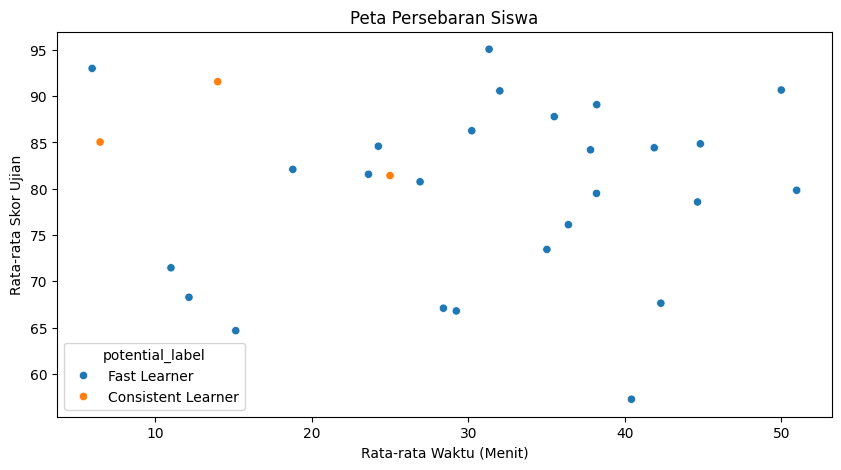

In [ ]:
# Visualisasi Sederhana
plt.figure(figsize=(10,5))
sns.scatterplot(data=final_df, x='avg_completion_time', y='avg_exam_score', hue='potential_label')
plt.title('Peta Persebaran Siswa')
plt.xlabel('Rata-rata Waktu (Menit)')
plt.ylabel('Rata-rata Skor Ujian')
plt.show()

## **Penambahan Data Dummy**

Data user kurang memadai untuk pelatihan model, jadi kami tambahkan data dummy

Gagal baca data asli, menggunakan default values.

--- DATASET SINTETIS FINAL ---
label
0    300
1    300
2    200
3    200
Name: count, dtype: int64

Contoh Data:
   avg_completion_time  total_modules_read  avg_exam_score  login_frequency  \
0            27.089310                  40       85.775183                3   
1            72.928266                   5       91.743632                3   
2            50.248888                  14       82.165603                5   
3            21.952146                  19       54.086653                3   
4            41.776345                  16       66.515463                1   

   failed_exams  label  
0             0      0  
1             0      2  
2             0      1  
3             2      3  
4             4      3  



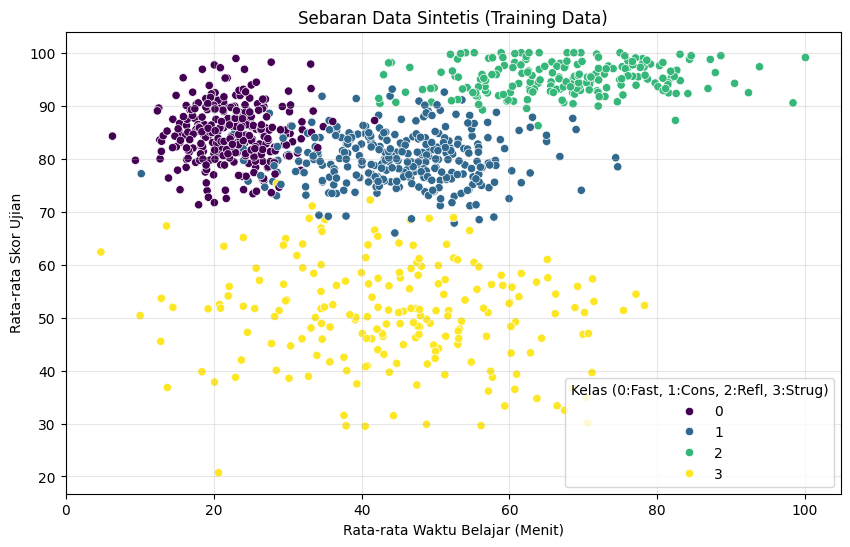


✅ File 'synthetic_training_data.csv' berhasil dibuat! Siap untuk Training Model.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. PERBAIKAN LOGIKA DATA ASLI
# ==========================================
# Kita load ulang sekadar untuk mengambil statistik dasar (mean/std)
# agar data palsu kita nanti angkanya "masuk akal" (tidak jauh beda dari asli)
try:
    df_tracking = pd.read_csv('developer_journey_trackings.csv')
    df_exam_res = pd.read_csv('exam_results.csv')

    # Hitung rata-rata durasi asli (untuk benchmark)
    df_tracking['first_opened_at'] = pd.to_datetime(df_tracking['first_opened_at'], errors='coerce')
    df_tracking['completed_at'] = pd.to_datetime(df_tracking['completed_at'], errors='coerce')
    valid_tracking = df_tracking[df_tracking['completed_at'].notnull()].copy()
    valid_tracking['duration'] = (valid_tracking['completed_at'] - valid_tracking['first_opened_at']).dt.total_seconds() / 60
    # Filter outlier ekstrem
    valid_tracking = valid_tracking[(valid_tracking['duration'] > 1) & (valid_tracking['duration'] < 600)]

    REAL_MEAN_TIME = valid_tracking['duration'].mean() if not valid_tracking.empty else 45.0
    REAL_STD_TIME = valid_tracking['duration'].std() if not valid_tracking.empty else 15.0

    print(f"Statistik Data Asli -> Avg Time: {REAL_MEAN_TIME:.2f} menit")
except:
    REAL_MEAN_TIME = 45.0
    REAL_STD_TIME = 20.0
    print("Gagal baca data asli, menggunakan default values.")

# ==========================================
# 2. GENERATE SYNTHETIC DATA (1000 Users)
# ==========================================
np.random.seed(42)
n_samples = 1000

# Kita buat 4 Cluster data berbeda agar model nanti pintar membedakan

# Cluster 0: Fast Learner
# Ciri: Cepat selesai (waktu rendah), Modul banyak, Nilai OK
fast = pd.DataFrame({
    'avg_completion_time': np.random.normal(loc=REAL_MEAN_TIME * 0.5, scale=5, size=300), # Lebih cepat
    'total_modules_read': np.random.randint(20, 50, size=300), # Banyak baca
    'avg_exam_score': np.random.normal(loc=85, scale=5, size=300),
    'login_frequency': np.random.randint(1, 4, size=300), # Login jarang tapi maraton
    'failed_exams': np.random.randint(0, 1, size=300),
    'label': 0 # Fast Learner
})

# Cluster 1: Consistent Learner
# Ciri: Waktu normal, Modul sedang, Login SERING (High Frequency)
consistent = pd.DataFrame({
    'avg_completion_time': np.random.normal(loc=REAL_MEAN_TIME, scale=10, size=300),
    'total_modules_read': np.random.randint(10, 30, size=300),
    'avg_exam_score': np.random.normal(loc=80, scale=5, size=300),
    'login_frequency': np.random.randint(5, 7, size=300), # Login hampir tiap hari
    'failed_exams': np.random.randint(0, 1, size=300),
    'label': 1 # Consistent Learner
})

# Cluster 2: Reflective Learner
# Ciri: Waktu LAMA (High Duration), Nilai TINGGI
reflective = pd.DataFrame({
    'avg_completion_time': np.random.normal(loc=REAL_MEAN_TIME * 1.5, scale=10, size=200), # Lama
    'total_modules_read': np.random.randint(5, 15, size=200), # Sedikit tapi dalam
    'avg_exam_score': np.random.normal(loc=95, scale=3, size=200), # Nilai nyaris sempurna
    'login_frequency': np.random.randint(2, 5, size=200),
    'failed_exams': np.random.randint(0, 1, size=200),
    'label': 2 # Reflective Learner
})

# Cluster 3: Struggling Learner
# Ciri: Nilai RENDAH, Banyak GAGAL
struggling = pd.DataFrame({
    'avg_completion_time': np.random.normal(loc=REAL_MEAN_TIME, scale=15, size=200),
    'total_modules_read': np.random.randint(5, 20, size=200),
    'avg_exam_score': np.random.normal(loc=50, scale=10, size=200), # Nilai rendah
    'login_frequency': np.random.randint(1, 4, size=200),
    'failed_exams': np.random.randint(2, 5, size=200), # Sering gagal
    'label': 3 # Struggling Learner
})

# Gabung semua
df_synthetic = pd.concat([fast, consistent, reflective, struggling], ignore_index=True)

# Clip nilai agar masuk akal (tidak negatif, max skor 100)
df_synthetic['avg_completion_time'] = df_synthetic['avg_completion_time'].clip(lower=1)
df_synthetic['avg_exam_score'] = df_synthetic['avg_exam_score'].clip(0, 100)
df_synthetic['login_frequency'] = df_synthetic['login_frequency'].clip(0, 7)
df_synthetic['failed_exams'] = df_synthetic['failed_exams'].clip(lower=0)

# Acak urutan data
df_synthetic = df_synthetic.sample(frac=1).reset_index(drop=True)

# ==========================================
# 3. CEK HASIL & SIMPAN
# ==========================================
print("\n--- DATASET SINTETIS FINAL ---")
print(df_synthetic['label'].value_counts())
print("\nContoh Data:")
print(df_synthetic.head())
print()

# Visualisasi untuk memastikan cluster terpisah dengan baik
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_synthetic, x='avg_completion_time', y='avg_exam_score', hue='label', palette='viridis')
plt.title('Sebaran Data Sintetis (Training Data)')
plt.xlabel('Rata-rata Waktu Belajar (Menit)')
plt.ylabel('Rata-rata Skor Ujian')
plt.legend(title='Kelas (0:Fast, 1:Cons, 2:Refl, 3:Strug)')
plt.grid(True, alpha=0.3)
plt.show()

# Simpan ke CSV
df_synthetic.to_csv('synthetic_training_data.csv', index=False)
print("\n✅ File 'synthetic_training_data.csv' berhasil dibuat! Siap untuk Training Model.")

# **Training Model**

In [ ]:
# install tensorflow.js
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


In [ ]:
# import library
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflowjs as tfjs

In [ ]:
# PERSIAPAN DATA
print("--- 1. MEMUAT & MEMPROSES DATA ---")
df = pd.read_csv('synthetic_training_data.csv')

# Pisahkan Fitur dan Label
# Urutan fitur HARUS SAMA dengan input JSON dari Backend nanti [cite: 37-43]
feature_names = ['avg_completion_time', 'total_modules_read', 'avg_exam_score', 'login_frequency', 'failed_exams']
X = df[feature_names].values
y = df['label'].values

# Normalisasi Data
# Kita simpan nilai scaler ini karena Backend/Frontend harus melakukan hal yang sama
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Scaler Parameters (Simpan ini untuk preprocessing.js nanti):")
print(f"Min: {scaler.data_min_}")
print(f"Scale: {scaler.scale_}")

# Split Data Training & Validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

--- 1. MEMUAT & MEMPROSES DATA ---
Scaler Parameters (Simpan ini untuk preprocessing.js nanti):
Min: [ 4.72817929  5.         20.71048635  1.          0.        ]
Scale: [0.01049117 0.02272727 0.01261201 0.2        0.25      ]


In [ ]:
# BANGUN & LATIH MODEL
print("--- 2. TRAINING MODEL NEURAL NETWORK ---")
model = tf.keras.Sequential([
    # Input Layer (5 Fitur)
    tf.keras.layers.InputLayer(input_shape=(5,)),

    # Hidden Layers
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),

    # Output Layer (4 Kelas: Fast, Consistent, Reflective, Struggling)
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Latih Model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)

# Evaluasi Singkat
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Akurasi Model pada Data Validasi: {accuracy*100:.2f}%")

--- 2. TRAINING MODEL NEURAL NETWORK ---
Akurasi Model pada Data Validasi: 100.00%


In [ ]:
# EXPORT KE TENSORFLOW.JS
print("--- 3. EXPORT KE FORMAT TF.JS ---")
output_path = 'output_project/model_tfjs'

# Hapus folder lama jika ada
if os.path.exists('output_project'):
    shutil.rmtree('output_project')

# Simpan model TF.js [cite: 28-32]
tfjs.converters.save_keras_model(model, output_path)
print(f"✅ Model tersimpan di: {output_path}")

--- 3. EXPORT KE FORMAT TF.JS ---
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model tersimpan di: output_project/model_tfjs


In [ ]:
# BUAT INSIGHT MAPPING JSON
print("--- 4. MEMBUAT FILE MAPPING INSIGHT ---")

# Sesuai spesifikasi JSON
insight_mapping = {
    "0": {
        "label": "Fast Learner",
        "motivation": "Wow, kecepatan belajarmu luar biasa! Jangan lupa istirahat.",
        "suggestions": [
            "Coba ambil tantangan coding tambahan (Expert Level).",
            "Bantu jawab pertanyaan teman di forum diskusi."
        ]
    },
    "1": {
        "label": "Consistent Learner",
        "motivation": "Konsistensi adalah kunci kesuksesan. Pertahankan!",
        "suggestions": [
            "Jadwalkan waktu belajar rutin 1 jam per hari.",
            "Review materi minggu lalu agar tidak lupa."
        ]
    },
    "2": {
        "label": "Reflective Learner",
        "motivation": "Pemahamanmu sangat mendalam. Nilai ujianmu membuktikannya.",
        "suggestions": [
            "Buat rangkuman materi dengan bahasamu sendiri.",
            "Eksplorasi dokumentasi resmi untuk detail lebih lanjut."
        ]
    },
    "3": {
        "label": "Struggling Learner",
        "motivation": "Jangan menyerah! Setiap ahli pernah menjadi pemula.",
        "suggestions": [
            "Coba ulangi materi fundamental di modul awal.",
            "Gunakan fitur tanya mentor jika mengalami kesulitan."
        ]
    }
}

# Simpan ke JSON
mapping_path = 'output_project/insight_mapping.json'
with open(mapping_path, 'w') as f:
    json.dump(insight_mapping, f, indent=4)

print(f"✅ Mapping file tersimpan di: {mapping_path}")

--- 4. MEMBUAT FILE MAPPING INSIGHT ---
✅ Mapping file tersimpan di: output_project/insight_mapping.json


In [ ]:
# SIMPAN INFO SCALING (UNTUK PREPROCESSING.JS)
scaling_info = {
    "feature_order": feature_names,
    "min_values": scaler.data_min_.tolist(),
    "scale_values": scaler.scale_.tolist()
}
with open('output_project/scaling_info.json', 'w') as f:
    json.dump(scaling_info, f, indent=4)
print("✅ Info scaling tersimpan (Penting untuk Frontend!)")

✅ Info scaling tersimpan (Penting untuk Frontend!)


In [ ]:
# ZIP HASIL AKHIR
shutil.make_archive('AI_Learning_Insight_Ready', 'zip', 'output_project')

'/content/AI_Learning_Insight_Ready.zip'